In [ ]:
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# tf-idf 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
#prune the keyword list
import re

# for stopwords
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

# models
### Random Forest model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix #draw matrix for report

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # do some calculation, ordering features

### Random Forest model
from sklearn.ensemble import RandomForestClassifier

### Linear SVC model 
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

#fine tuning
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /home/keen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/keen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### both of w2v and tf-idf are methods that i use in my project to expand the keyword list to collect more data from internet, iterate it for multiple rounds we could get a quite exhaustive keyword list, and hence a dataset with high relevent apps.

### a short illustration for W2V based on wiki articles.
##### this approach didn't do a better job than td-idf, so here is just to illustrate via different resources.

In [69]:
def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and t not in punctuations]
    return tokens

# read files from wiki_articles folder(medical technology related ones)
corpus = []
folder_path = 'wiki_articles'

input_dir = 'wiki_articles'
for filename in os.listdir(input_dir):
    print("read file", filename)  # log
    


for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            tokens = preprocess(text)
            corpus.append(tokens)

print(f"read and pre_process {len(corpus)} file.")

# train Word2Vec model
model = Word2Vec(
    sentences=corpus,
    vector_size=200,
    window=5,
    min_count=3,
    workers=5,
    sg=1
)

# save the model
model.save('domain_word2vec.model')

print("log: W2V model is trained and saved")

# test similarity single words
print(model.wv.most_similar('medicine', topn=20))

read file Medical_Technology.txt
read file pharmaceutical_drug.txt
read file Good_clinical_practice.txt
read file bio-medicine.txt
read file GxP.txt
read file healthcare_software.txt
read file Assistive_technologies.txt
read file Medical_imaging.txt
read file Life_science.txt
read file Robot-assisted_surgery.txt
read file Health_information_exchange.txt
read file Pharmaceutical_industry.txt
read and pre_process 12 file.
log: W2V model is trained and saved
[('regulation', 0.9812163710594177), ('bringing', 0.9795956611633301), ('blockbuster', 0.978645920753479), ('sales', 0.9785687923431396), ('pharmacology', 0.9774569272994995), ('required', 0.9773654341697693), ('ich', 0.9767444729804993), ('history', 0.9767135381698608), ('identifying', 0.9763835072517395), ('marketing', 0.9762572646141052), ('potential', 0.9753803610801697), ('humira', 0.9749389886856079), ('developing', 0.9749064445495605), ('involves', 0.9749042987823486), ('candidates', 0.9748649597167969), ('expensive', 0.9747226

In [70]:
# test keywords list
test_words = ["approval", "pharmaceutical", "robot", "clinical", "software", "treatment", "regulatory"]

# check top 10 similar words
for word in test_words:
    print(f"\n“{word}” 's most similar word is")
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=10)
        for w, score in similar_words:
            print(f"  {w:<20} similarity:{score:.4f}")
    else:
        print(f"!!! Word “{word}” not in glossary")


“approval” 's most similar word is
  product              similarity:0.9964
  blockbuster          similarity:0.9961
  expensive            similarity:0.9956
  bringing             similarity:0.9955
  humira               similarity:0.9952
  year                 similarity:0.9948
  history              similarity:0.9946
  manufacturers        similarity:0.9945
  government           similarity:0.9944
  india                similarity:0.9944

“pharmaceutical” 's most similar word is
  billion              similarity:0.9715
  companies            similarity:0.9690
  industry             similarity:0.9636
  administration       similarity:0.9564
  drugs                similarity:0.9560
  food                 similarity:0.9548
  fda                  similarity:0.9529
  market               similarity:0.9496
  development          similarity:0.9494
  discovery            similarity:0.9479

“robot” 's most similar word is
  vinci                similarity:0.9969
  da                   simil

In [71]:
# classifier required keywords
key_words = ["medical", "technology", "life science", "GxP", "Pharma"]

# check top 10 similar words
for word in test_words:
    print(f"\n“{word}” 's most similar word is")
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=10)
        for w, score in similar_words:
            print(f"  {w:<20} similarity:{score:.4f}")
    else:
        print(f"!!! Word “{word}” not in glossary")


“approval” 's most similar word is
  product              similarity:0.9964
  blockbuster          similarity:0.9961
  expensive            similarity:0.9956
  bringing             similarity:0.9955
  humira               similarity:0.9952
  year                 similarity:0.9948
  history              similarity:0.9946
  manufacturers        similarity:0.9945
  government           similarity:0.9944
  india                similarity:0.9944

“pharmaceutical” 's most similar word is
  billion              similarity:0.9715
  companies            similarity:0.9690
  industry             similarity:0.9636
  administration       similarity:0.9564
  drugs                similarity:0.9560
  food                 similarity:0.9548
  fda                  similarity:0.9529
  market               similarity:0.9496
  development          similarity:0.9494
  discovery            similarity:0.9479

“robot” 's most similar word is
  vinci                similarity:0.9969
  da                   simil

In [72]:
#check phrases: bigram

# stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

# preprocess and filter
def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and t not in punctuations]
    return tokens

# same as before
corpus = []
folder_path = 'wiki_articles'

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        print("read file: ", filename)  # log
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            tokens = preprocess(text)
            corpus.append(tokens)

print(f"read and preprocess {len(corpus)} files")

### phrase
print("building starts")
# build bigram model
phrases = Phrases(corpus, min_count=3, threshold=10, delimiter='_')  # delimiter is _
bigram = Phraser(phrases)

# if exist then replace
phrased_corpus = list(bigram[corpus])

# check some of the replaced phrased
# print(phrased_corpus[0][:20])
print("building finished")
###

# train Word2Vec model with phrases
print("Word2Vec Model training: phrase version")
model_phrase = Word2Vec(
    sentences=phrased_corpus,
    vector_size=200,
    window=5,
    min_count=3,
    workers=5,
    sg=1
)

# save
model_phrase.save('domain_word2vec_with_phrases.model')
print("model is trained")

# most similar word
print(model_phrase.wv.most_similar('medicine', topn=10))

# check if a phrase is in the glossary
print('clinical_trial' in model_phrase.wv)
print(model_phrase.wv.most_similar('clinical_trial'))


read file:  Medical_Technology.txt
read file:  pharmaceutical_drug.txt
read file:  Good_clinical_practice.txt
read file:  bio-medicine.txt
read file:  GxP.txt
read file:  healthcare_software.txt
read file:  Assistive_technologies.txt
read file:  Medical_imaging.txt
read file:  Life_science.txt
read file:  Robot-assisted_surgery.txt
read file:  Health_information_exchange.txt
read file:  Pharmaceutical_industry.txt
read and preprocess 12 files
building starts
building finished
Word2Vec Model training: phrase version
model is trained
[('pharmacology', 0.9971185326576233), ('molecular', 0.9970302581787109), ('known', 0.9970038533210754), ('century', 0.9969363808631897), ('drug_development', 0.9968870282173157), ('discovery', 0.9968695640563965), ('research_development', 0.9967206120491028), ('medicinal', 0.9966995120048523), ('generally', 0.9966737627983093), ('medieval', 0.9966713786125183)]
True
[('payment', 0.9991761445999146), ('requires', 0.9991136193275452), ('overall', 0.9990949034

In [73]:
shortlist_p = [w for w in model_phrase.wv.index_to_key if '_' in w]
print(shortlist_p[:20])  # check phrase

['assistive_technology', 'united_states', 'medical_imaging', 'medical_device', 'health_information', 'pharmaceutical_industry', 'robotic_surgery', 'clinical_trials', 'medical_devices', 'da_vinci', 'pharmaceutical_companies', 'drug_discovery', 'medical_software', 'drug_development', 'healthcare_providers', 'health_care', 'magnetic_resonance', 'see_also', 'assistive_technologies', 'augmentative_alternative']


In [74]:
# check if a phrase is in the glossary
print('assistive_technology' in model_phrase.wv)
print(model_phrase.wv.most_similar('assistive_technology'))

print('medical_imaging' in model_phrase.wv)
print(model_phrase.wv.most_similar('medical_imaging'))

True
[('devices', 0.9944892525672913), ('adaptive_technology', 0.9943587779998779), ('sports', 0.994245171546936), ('use', 0.9939935803413391), ('adaptive', 0.9935490489006042), ('may', 0.9934042692184448), ('disabled_people', 0.9930504560470581), ('disabilities', 0.9929558634757996), ('include', 0.9928868412971497), ('wheelchairs', 0.992766261100769)]
True
[('ultrasound', 0.9979981184005737), ('magnetic_resonance', 0.9977809190750122), ('applications', 0.9972584843635559), ('imaging_mri', 0.9970636367797852), ('image', 0.9970116019248962), ('equipment', 0.9969574213027954), ('modalities', 0.9968090653419495), ('tactile', 0.9967610239982605), ('radiology', 0.9967363476753235), ('mri', 0.9967225790023804)]


##### for longer phrase we need more data to train the model, and due to replacement doesn't happened that often(minimal threshold = 3), we mostly get the most similar single word for key phrases rather than phrases.

### a short illustration for tf-idf based on annotated dataset(google play).
### use this dataset to train models: SVM and Random Forest

In [75]:
def extract_keywords_tfidf(df, text_column='description', existing_keywords=None, lang='english', max_features=100):
    '''
    extract TF-IDF keywords from given DataFrame's description columns, return a list of keywords

    Parameters:
    1, df: pandas DataFrame
    2, text_column:  'description'
    3, existing_keywords: remove duplication of already existing keywords
    4, lang: stopwords, default is 'english'
    5, max_features: default = 100

    return:
    r, new_keywords: list
    '''
    # 1. check if there is already existing keywords
    if existing_keywords is None:
        existing_keywords = []

    # 2. TfidfVectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words=stopwords.words(lang)
    )

    # 3. remove null terms
    X = vectorizer.fit_transform(df[text_column].dropna())

    # 4. get keywords
    tfidf_keywords = vectorizer.get_feature_names_out()

    # 5. remove duplication or noise
    new_keywords = list(set(tfidf_keywords) - set(existing_keywords))

    # 6. print them out
    print(f"Extracted {len(new_keywords)} new keywords (top {len(new_keywords)} shown):")
    print(new_keywords)
    return new_keywords

In [76]:
# read annotated data from csv file
with open('annotated_google_backup_version.csv', encoding='utf-8', errors='ignore') as f:
    data = pd.read_csv(f)   
# print(data.head())

# preprocess the text: 
def clean_text(text):
    if not isinstance(text, str):  # check if it's string
        return ''
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # remove special symbol other than letter or number
    return text

data['clean_description'] = data['description'].apply(clean_text)
data = data.dropna(subset=['label', 'clean_description']) #remove empty terms

# print(data[['description', 'clean_description']].head()) # print to check
keywords_google_tfidf = extract_keywords_tfidf(data,'clean_description',['google','www','best','subscription','000'],'english')

Extracted 95 new keywords (top 95 shown):
['based', 'find', 'offers', 'help', 'medical', 'tracking', 'home', 'make', 'questions', 'pharmacy', 'medications', 'healthcare', 'weight', 'daily', 'account', 'like', 'topics', 'full', 'one', 'terms', 'doctor', 'tracker', 'stay', 'see', 'medicine', 'support', 'get', 'online', 'com', 'fitness', 'medication', 'including', 'rx', 'care', 'using', 'device', 'system', 'search', 'time', 'need', 'manage', 'patient', 'management', 'save', 'https', 'clinical', 'order', 'download', 'data', 'drug', 'prescriptions', 'free', 'study', 'quiz', 'easy', 'life', 'notes', 'world', 'prescription', 'plant', 'features', 'every', 'period', 'knowledge', 'biology', 'us', 'learn', 'test', 'new', 'students', 'available', 'use', 'user', 'access', 'track', 'experience', 'reminders', 'take', 'practice', 'sleep', 'privacy', 'app', 'science', 'learning', 'exam', 'content', 'easily', 'information', 'check', 'store', 'mobile', 'health', 'view', 'conditions', 'also']


In [77]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

SVM Report:
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        20
         1.0       0.93      0.93      0.93        42

    accuracy                           0.90        62
   macro avg       0.89      0.89      0.89        62
weighted avg       0.90      0.90      0.90        62



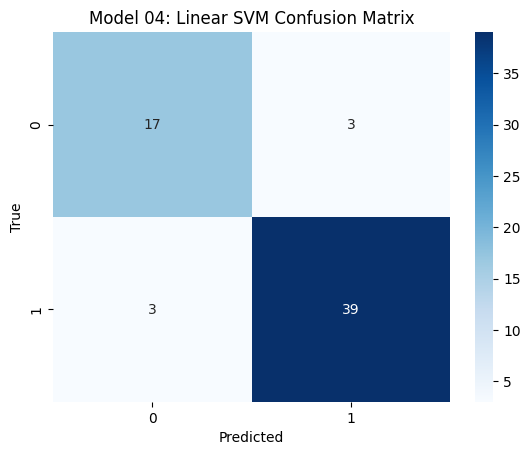

In [78]:
##### Model Linear SVM
# original text X： data['clean_description']
X = data['clean_description']
y = data['label']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# pipeline：TF-IDF extract，then train, claasic default setting
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', LinearSVC())
])

# train
svm_pipeline.fit(X_train, y_train)

# predict
y_pred_svm = svm_pipeline.predict(X_test)

# evaluation
print("SVM Report:")
print(classification_report(y_test, y_pred_svm))
plot_confusion_matrix(y_test, y_pred_svm, 'Model 04: Linear SVM Confusion Matrix')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END clf__C=0.1, clf__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; total time=   0.1s
[CV] END clf__C=0.1, clf__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; total time=   0.2s
[CV] END clf__C=0.1, clf__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; total time=   0.2s
[CV] END clf__C=0.1, clf__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; total time=   0.2s
[CV] END clf__C=0.1, clf__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=None; total time=   0.2s
[CV] END clf__C=0.1, clf__loss=hinge, tfidf__max_df=0.9, tfidf__max_featur

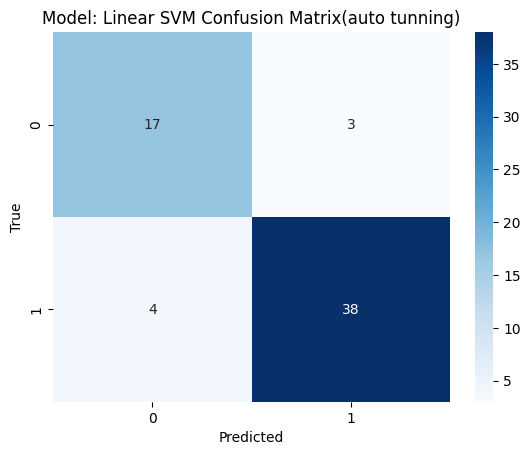

In [79]:
# auto tunning SVM
# data
X = data['clean_description']
y = data['label']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# param_grid 
# ''' 
param_grid = {
    'tfidf__max_features': [1000, 3000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)], # check bigram
    'tfidf__min_df': [1, 3],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__stop_words': ['english', None], # stopwords
    'clf__C': [0.1, 1, 10],
    'clf__loss': ['hinge','squared_hinge'] #best combination using hinge for loss?
}
# '''

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)

# train
grid_search.fit(X_train, y_train)

# best
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# do predication 
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# report
print("Final Evaluation on Test Set(auto tunning):")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, 'Model: Linear SVM Confusion Matrix(auto tunning)')


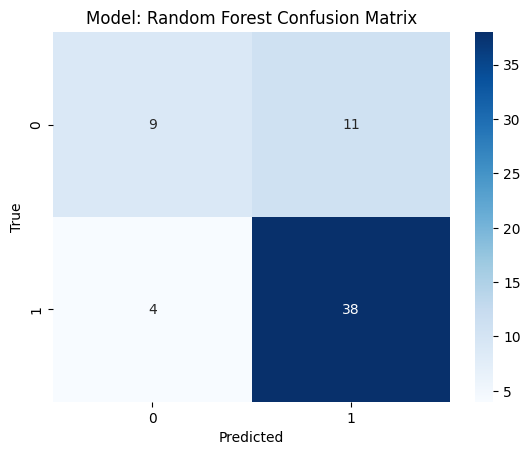

Random Forest Report:
               precision    recall  f1-score   support

         0.0       0.69      0.45      0.55        20
         1.0       0.78      0.90      0.84        42

    accuracy                           0.76        62
   macro avg       0.73      0.68      0.69        62
weighted avg       0.75      0.76      0.74        62



In [80]:
#  Model Random Forest
tfidf_vect = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vect.fit_transform(data['clean_description'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

plot_confusion_matrix(y_test, y_pred_rf, 'Model: Random Forest Confusion Matrix')
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_e

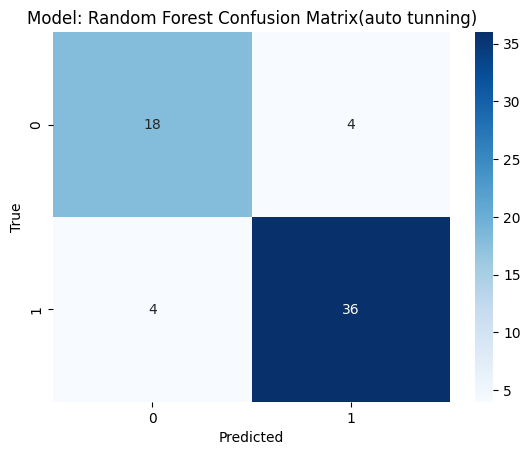

Random Forest Report(auto tunning):
               precision    recall  f1-score   support

         0.0       0.82      0.82      0.82        22
         1.0       0.90      0.90      0.90        40

    accuracy                           0.87        62
   macro avg       0.86      0.86      0.86        62
weighted avg       0.87      0.87      0.87        62



In [81]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# extract feature
tfidf_vect = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vect.fit_transform(data['clean_description'])
y = data['label']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# def
rf = RandomForestClassifier(random_state=42)

# grid
param_grid = {
    'n_estimators': [50, 100, 150],         
    'max_depth': [None, 10, 20],        
    'min_samples_split': [2, 5, 10],        
    'min_samples_leaf': [1, 2, 4],          
    'max_features': ['sqrt', 'log2',0.5]   
}

# GridSearchCV 
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# train and optimize param
grid_search.fit(X_train, y_train)

# best
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# evaluation and report
y_pred = grid_search.predict(X_test)
plot_confusion_matrix(y_test, y_pred, 'Model: Random Forest Confusion Matrix(auto tunning)')
print("Random Forest Report(auto tunning):\n", classification_report(y_test, y_pred))


##### as above showed, random forest improve a lot after auto tunning and find a best combination of parameters, but SVM's performance didn't change much after auto tunning, it's more stable because of the contruction of the model itself.